## In-Depth Analysis/ Machine Learning

## Capstone Project 1: Lending Club Data - Predicting Return on Investment for Investors

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#### Load Data and Prepare for Modelling

First I will load the data and prepare it for modelling.  I will create the depended variable, ROI, create dummies for the categorical variables, and scale the data numerical data.   I will also split the data into train, validation, and test sets.

In [3]:
loans = pd.read_csv('loans_clean.csv')

In [4]:
dtypes = loans.dtypes
object_vars = list(dtypes[dtypes == 'object'].index)
int_vars = list(dtypes[dtypes == 'int64'].index)
loans[object_vars] = loans[object_vars].astype('category')
loans[int_vars] = loans[int_vars].astype('float64')
loans['roi'] = (loans['total_pymnt'] - loans['funded_amnt']) / loans['funded_amnt']

In [5]:
high_corr = ['num_actv_rev_tl', 'tot_cur_bal', 'open_acc', 'installment']
drop_cols = ['zip_code', 'issue_d', 'total_pymnt', 'sub_grade', 'loan_status']

In [6]:
loans.drop(high_corr, axis = 1, inplace = True)
loans.drop(drop_cols, axis = 1, inplace = True)

In [7]:
from sklearn.preprocessing import StandardScaler
X = loans.drop('roi', axis = 1)
y = loans['roi']
num_vars = X.select_dtypes(include = 'number')
cat_vars = X.select_dtypes(include = 'category')
cat_vars_dummy = pd.get_dummies(cat_vars, drop_first = True)

scaler = StandardScaler()

num_vars_scaled = pd.DataFrame(scaler.fit_transform(num_vars), columns= num_vars.columns)

X = pd.concat([cat_vars_dummy, num_vars_scaled], axis = 1)

#### Split Data into Train, Validaton, and  Test Data

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_intermediate, X_test, y_intermediate, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train, X_validation, y_train, y_validation = train_test_split(X_intermediate, y_intermediate, test_size = 0.25, random_state = 42)

In [9]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(96489, 146)
(32163, 146)
(32163, 146)


## Modeling

The data was split into train, validation, and test sets, as I plan to use the validation set for hyperparameter tuning rather than cross-validation due to the size of the data set and computational limitations.

First I will run a linear regression, random forest, and gradient boosting model with the defaults and no tuning to get some baseline scores.

I will evaluate performance based on the following metrics:

 - Validation Scores (R^2)

 - Mean Absolute Error (MAE)

 - Root Mean Squared Error (RMSE)

 - Residual plot and histogram.
 
 - Residuals 90th Percentile
 
I expect it to be difficult to get a high R-squared value predicting ROI for several reasons.  First, since I am predicting the ROI instead of the dollar amount repaid, I will not have the original loan amount as a strong predictor. By predicting the ROI instead of the amount repaid, I am taking away the given that a larger loan is expected to have a higher repayment amount, and reducing the prediction to the profitability of the loan as a percentage of the original loan amount.

Second, there is an inherent difficulty in predicting exactly which loans will have a poor ROI score, as there is a randomness to the actual causes of a poor score, such as the borrower not repaying their loan due to losing their job.  In the case of job loss resulting in a defaulting loan with a poor ROI, I expect it to be difficult to predict precisely which loans that will happen to, but hopefully the model will still reduce the risk by assigning a lower prediction for the loans that are more likely to perform poorly.

Despite the challenges in achiving a high score, even a lower score should allow the investor to choose more profitable loans than with no model at all.

I'll create a function to calculate the 90th percentile of the residuals.

In [10]:
def calculate_residual_percentile(pred, actual, percentile):
    """Calculate percentile bounds of positive and negative residuals"""
    import numpy as np
    resid = actual - pred
    
    #Create Positive and Negative Condition Arrays
    condition_pos = resid > 0
    condition_neg = resid < 0
    
    #Create arrays for positive and negative residuals
    pos_residuals = np.extract(condition_pos, resid)
    neg_residuals = np.extract(condition_neg, resid)
    
    #Calculate Percentile
    pos_percentile = np.percentile(pos_residuals, percentile)
    neg_percentile = np.percentile(neg_residuals, 100-percentile)
    pos_percentile = round(pos_percentile,4)
    neg_percentile = round(neg_percentile,4)
    return neg_percentile, pos_percentile

## Baseline Models

First, I will run the three models with just the default parameters to get baseline scores. 

#### Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [12]:
lr.intercept_

0.12529209422511198

In [13]:
df_coefs = pd.DataFrame(lr.coef_, index=X.columns, columns = ['Coefficient'])
df_coefs['Abs_Coefficient'] = abs(df_coefs.Coefficient)
df_coefs.sort_values('Abs_Coefficient', ascending = False).head(10)
    

,Coefficient,Abs_Coefficient
addr_state_UT,-0.056660,0.056660
addr_state_NV,-0.051905,0.051905
purpose_small_business,-0.046988,0.046988
addr_state_NJ,-0.046298,0.046298
addr_state_NY,-0.042119,0.042119
addr_state_CT,-0.041899,0.041899
addr_state_FL,-0.041514,0.041514
addr_state_TN,-0.041441,0.041441
addr_state_NM,-0.040435,0.040435
addr_state_MI,-0.040355,0.040355


In [14]:
from sklearn.metrics import mean_squared_error

lr_predictions = lr.predict(X_validation)
lr_train_score = lr.score(X_train, y_train)
lr_validation_score = lr.score(X_validation, y_validation)
lr_mae = np.mean(abs(lr_predictions - y_validation))
lr_rmse = np.sqrt(mean_squared_error(y_validation, lr_predictions))

In [15]:
print('Base Linear Regression Train Score:      ', lr_train_score)
print('Base Linear Regression Validation Score: ', lr_validation_score)
print('Base Linear Regression MAE:              ',lr_mae)
print('Base Linear Regression RMSE:             ',lr_rmse)

Base Linear Regression Train Score:       0.04884080017731684
Base Linear Regression Validation Score:  0.04731168637184946
Base Linear Regression MAE:               0.16368174500533897
Base Linear Regression RMSE:              0.2555979396257154


The base linear regression model has a validation score of 0.047, which isn pretty low.

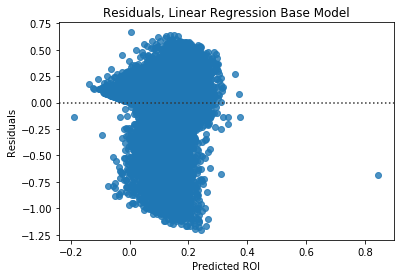

In [16]:
sns.residplot(x = lr_predictions, y = y_validation - lr_predictions)
plt.title('Residuals, Linear Regression Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

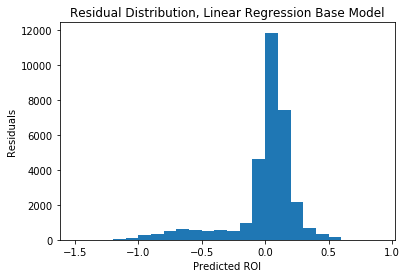

In [17]:
plt.hist(y_validation - lr_predictions, bins = np.arange(-1.5, 1, 0.1))
plt.title('Residual Distribution, Linear Regression Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

In [18]:
lr_90_percentile = calculate_residual_percentile(lr_predictions, y_validation ,90)
print('Base Linear Regression Residuals, 90th percentile: ', lr_90_percentile)

Base Linear Regression Residuals, 90th percentile:  (-0.7594, 0.2355)


The residuals are centered above zero and have a long tail towards the negative side. This long tail represents the loans that have a low ROI that isnt being picked up by the model. 90 percent of the resisuals fall within an ROI range between -75.94% and 23.546%.

#### Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs = -1, n_estimators = 100, random_state = 42, oob_score = True)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [20]:
rf_predictions = rf.predict(X_validation)
rf_train_score = rf.score(X_train, y_train)
rf_validation_score = rf.score(X_validation, y_validation)
rf_mae = np.mean(abs(rf_predictions - y_validation))
rf_rmse = np.sqrt(mean_squared_error(y_validation, rf_predictions))

In [21]:
print('Base Random Forest Train Score:      ', rf_train_score)
print('Base Random OOB Score:               ', rf.oob_score_)
print('Base Random Forest Validation Score: ', rf_validation_score)
print('Base Random Forest MAE:              ',rf_mae)
print('Base Random Forest RMSE:             ',rf_rmse)

Base Random Forest Train Score:       0.8911574507001414
Base Random OOB Score:                0.2091389903552513
Base Random Forest Validation Score:  0.22654432048097828
Base Random Forest MAE:               0.14282674792741365
Base Random Forest RMSE:              0.2303030269818964


The random forest model has a much better validation score of 0.227 compared to the linear regression which scored 0.047.  

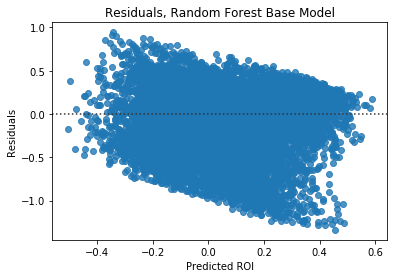

In [22]:
sns.residplot(x = rf_predictions, y = y_validation - rf_predictions)
plt.title('Residuals, Random Forest Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

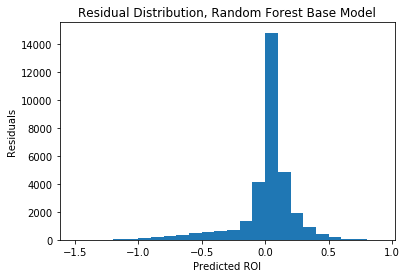

In [23]:
plt.hist(y_validation - rf_predictions, bins = np.arange(-1.5, 1, 0.1))
plt.title('Residual Distribution, Random Forest Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

In [24]:
rf_90_percentile = calculate_residual_percentile(rf_predictions, y_validation ,90)
print('Base Random Forest Residuals, 90th percentile: ', rf_90_percentile)

Base Random Forest Residuals, 90th percentile:  (-0.645, 0.2529)


The residuals are centered just above zero,  and also show a tail on the negative side, indicating loans with where the model over-estimating the low ROI. 90 Percent of the residuals are between -64.5% and 25.3% ROI.

#### Gradient Boosting

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

boost = GradientBoostingRegressor(random_state = 42)
boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
boost_predictions = boost.predict(X_validation)
boost_train_score = boost.score(X_train, y_train)
boost_validation_score = boost.score(X_validation, y_validation)
boost_mae = np.mean(abs(boost_predictions - y_validation))
boost_rmse = np.sqrt(mean_squared_error(y_validation, boost_predictions))

In [27]:
print('Base Gradient Boost Train Score:     ', boost_train_score)
print('Base Gradient Boost Validation Score:', boost_validation_score)
print('Base Gradient Boost MAE:             ', boost_mae)
print('Base Gradient Boost RSME:            ',boost_rmse)

Base Gradient Boost Train Score:      0.20073252680517573
Base Gradient Boost Validation Score: 0.19409240226094393
Base Gradient Boost MAE:              0.14550951589814887
Base Gradient Boost RSME:             0.2350848027878787


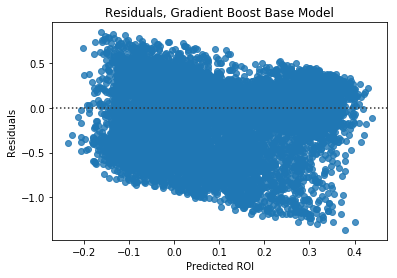

In [28]:
sns.residplot(x = boost_predictions, y = y_validation - boost_predictions)
plt.title('Residuals, Gradient Boost Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

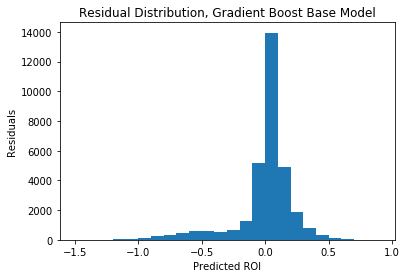

In [29]:
plt.hist(y_validation - boost_predictions, bins = np.arange(-1.5, 1, 0.1))
plt.title('Residual Distribution, Gradient Boost Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

In [30]:
boost_90_percentile = calculate_residual_percentile(boost_predictions, y_validation ,90)
print('Base Gradient Boost Residuals, 90th percentile: ', boost_90_percentile)

Base Gradient Boost Residuals, 90th percentile:  (-0.6596, 0.2422)


The gradient boost baseline model performed slightly worse on the validation score than the random forest. The positive residuals have a heavy tail indicating cases where the model is not picking up on the really low ROIs.

#### Base Model Summary

In [31]:

print('Base Linear Regression:')
print(' Train Score:      ', lr_train_score)
print(' Validation Score: ', lr_validation_score)
print(' MAE:              ', lr_mae)
print(' RMSE:             ', lr_rmse)
print('-'*72)
print('Base Random Forest:')
print(' Train Score:      ', rf_train_score)
print(' Validation Score: ', rf_validation_score)
print(' MAE:              ', rf_mae)
print(' RMSE:             ', rf_rmse)
print('-'*72)
print('Base Gradient Boost:')
print(' Train Score:      ', boost_train_score)
print(' Validation Score: ', boost_validation_score)
print(' MAE:              ', boost_mae)
print(' RSME:             ', boost_rmse)

Base Linear Regression:
 Train Score:       0.04884080017731684
 Validation Score:  0.04731168637184946
 MAE:               0.16368174500533897
 RMSE:              0.2555979396257154
------------------------------------------------------------------------
Base Random Forest:
 Train Score:       0.8911574507001414
 Validation Score:  0.22654432048097828
 MAE:               0.14282674792741365
 RMSE:              0.2303030269818964
------------------------------------------------------------------------
Base Gradient Boost:
 Train Score:       0.20073252680517573
 Validation Score:  0.19409240226094393
 MAE:               0.14550951589814887
 RSME:              0.2350848027878787


For the base models, the random forest is performing the best on the validation score, MAE, and RMSE, with the gradient boost performing just slightly worse. The base linear regression is a distant third place based on the validation score, however, the MAE and RMSE are not too far behind the ensemble models.

## Model Tuning

#### Linear Regression  Tuning

To tune the linear regression model, I will try fitting a ridge and lasso model to apply regularization and see if the results imprive. I don't expect a large gain since overfitting does not appear to be a problem with the baseline model. Based on the low score of on the training set, it most likely underfitting.

In [32]:
from sklearn.linear_model import Ridge

alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alphas:
    
    ridge = Ridge(alpha = alpha, fit_intercept = True, random_state = 1)
    ridge.fit(X_train, y_train)
    train_error = np.sqrt(mean_squared_error(y_train, ridge.predict(X_train)))
    validation_error = np.sqrt(mean_squared_error(y_validation, ridge.predict(X_validation)))
    print('alpha: {:7} | train error: {:5} | val error: {:6}'.
          format(alpha,
                 round(train_error,10),
                 round(validation_error,10)))
  

alpha:   1e-06 | train error: 0.2551343656 | val error: 0.2555979396
alpha:   1e-05 | train error: 0.2551343656 | val error: 0.2555979396
alpha:  0.0001 | train error: 0.2551343656 | val error: 0.2555979397
alpha:   0.001 | train error: 0.2551343656 | val error: 0.2555979399
alpha:    0.01 | train error: 0.2551343656 | val error: 0.2555979422
alpha:     0.1 | train error: 0.2551343666 | val error: 0.2555979655
alpha:       1 | train error: 0.255134446 | val error: 0.2555981847
alpha:      10 | train error: 0.2551363128 | val error: 0.2555983775
alpha:     100 | train error: 0.2551434728 | val error: 0.2555802156


In [33]:
ridge = Ridge(alpha = .00001)
ridge.fit(X_train, y_train)

Ridge(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [34]:
from sklearn.linear_model import Lasso

In [35]:
from sklearn.linear_model import Lasso

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for alpha in alphas:
    
    lasso = Lasso(alpha = alpha, fit_intercept = True, random_state = 1)
    lasso.fit(X_train, y_train)
    new_train_error = np.sqrt(mean_squared_error(y_train, lasso.predict(X_train)))
    new_validation_error = np.sqrt(mean_squared_error(y_validation, lasso.predict(X_validation)))
    print('alpha: {:7} | train error: {:5} | val error: {:6}'.
          format(alpha,
                 round(new_train_error,10),
                 round(new_validation_error,10)))

alpha:   1e-05 | train error: 0.2551420087 | val error: 0.2555854258
alpha:  0.0001 | train error: 0.2552358275 | val error: 0.2555593454
alpha:   0.001 | train error: 0.2557176739 | val error: 0.2559478222
alpha:    0.01 | train error: 0.2574420086 | val error: 0.257795947
alpha:     0.1 | train error: 0.2616027794 | val error: 0.2618680913
alpha:       1 | train error: 0.2616027794 | val error: 0.2618680913
alpha:      10 | train error: 0.2616027794 | val error: 0.2618680913


In [36]:
lasso = Lasso(alpha = .0001)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [37]:
lasso_train_score = lasso.score(X_train, y_train)
lasso_validation_score = lasso.score(X_validation, y_validation)


print('Base Linear Regression Train Score:      ', lr.score(X_train, y_train))
print('Base Linear Regression Validation Score: ', lr.score(X_validation, y_validation))
print('-'*72)
print('Ridge Regression Train Score:            ', ridge.score(X_train, y_train))
print('Ridge Regression Validation Score:       ', ridge.score(X_validation, y_validation))
print('-'*72)
print('Lasso Regression Train Score:            ', lasso_train_score)
print('Lasso Regression Validaton Score:        ', lasso_validation_score)

Base Linear Regression Train Score:       0.04884080017731684
Base Linear Regression Validation Score:  0.04731168637184946
------------------------------------------------------------------------
Ridge Regression Train Score:             0.048840800177316734
Ridge Regression Validation Score:        0.04731168635249383
------------------------------------------------------------------------
Lasso Regression Train Score:             0.048084135149472296
Lasso Regression Validaton Score:         0.04759936851391777


The lasso regularization is with an alpha value of 0.0001 is performing the best on the validation data, however, the gain is minimal. The ridge regression only has a very slight improvement over the baseline linear regression. 

In [38]:
lasso_predictions = lasso.predict(X_validation)
lasso_mae = np.mean(abs(lasso_predictions - y_validation))
lasso_rmse = np.sqrt(mean_squared_error(y_validation, lasso_predictions))

print('Base Linear Regression MAE:   ',lr_mae)
print('Base Linear Regression RMSE:  ',lr_rmse)
print('Lasso Regresson MAE:          ',lasso_mae)
print('Lasso Regression RSME:        ', lasso_rmse)

Base Linear Regression MAE:    0.16368174500533897
Base Linear Regression RMSE:   0.2555979396257154
Lasso Regresson MAE:           0.16346891966433677
Lasso Regression RSME:         0.2555593454110179


The Lasso model also shows a minimal improvement on the MAE and RMSE metrics.

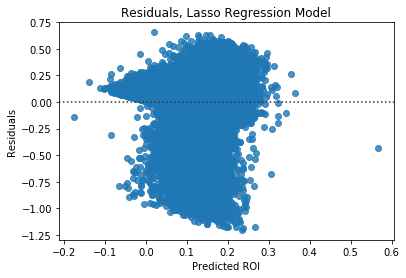

In [39]:
sns.residplot(x = lasso_predictions, y = y_validation - lasso_predictions)
plt.title('Residuals, Lasso Regression Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

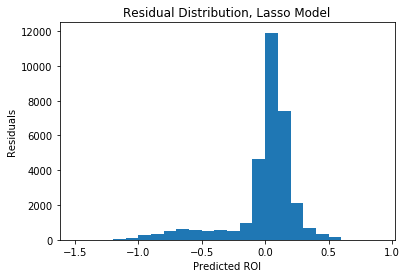

In [40]:
plt.hist(y_validation - lasso_predictions, bins = np.arange(-1.5, 1, 0.1))
plt.title('Residual Distribution, Lasso Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

In [41]:
lasso_90_percentile = calculate_residual_percentile(lasso_predictions, y_validation ,90)
print('Lasso Residuals, 90th percentile: ', lasso_90_percentile)

Lasso Residuals, 90th percentile:  (-0.7592, 0.2359)


As with the base model, the residuals are still centered above zero, and the negative residuals have a heavy tail. The base linear regression appears to be underfitting rather than overfitting based on the low overall score, the narrow range of prediction values, and the lack of improvement with lasso regularization.

#### Random Forest Tuning

First I will look at the feature imporatances and try dropping some unimportant variables.

In [42]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X.columns, columns = ['importance']).sort_values('importance', ascending = False)
print(feature_importances.head(10))
print(feature_importances.tail(10))

                         importance
days_since_last_cr_pull    0.169896
int_rate                   0.056123
term_ 60 months            0.042070
dti                        0.029712
revol_util                 0.026469
annual_inc                 0.026297
mo_sin_old_il_acct         0.026269
funded_amnt                0.024518
bc_util                    0.022568
days_of_credit_hist        0.021515
                            importance
addr_state_RI                 0.000467
collections_12_mths_ex_med    0.000434
delinq_amnt                   0.000394
grade_G                       0.000353
chargeoff_within_12_mths      0.000339
addr_state_MT                 0.000277
acc_now_delinq                0.000142
num_tl_30dpd                  0.000130
purpose_renewable_energy      0.000101
num_tl_120dpd_2m              0.000044


In [43]:
drop_cols_rf = list(feature_importances[feature_importances.importance < 0.0015].index)
len(drop_cols_rf)

70

In [44]:
X_2 = X.drop(drop_cols_rf, axis = 1)

X_2_intermediate, X_2_test, y_2_intermediate, y_2_test = train_test_split(X_2, y, test_size = 0.2, random_state = 42)

X_2_train, X_2_validation, y_2_train, y_2_validation = train_test_split(X_2_intermediate, y_2_intermediate, test_size = 0.25, random_state = 42)


In [45]:
rf_2 = RandomForestRegressor(n_jobs = -1, n_estimators = 100, random_state = 42)

rf_2.fit(X_2_train, y_2_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [46]:
rf_2_predictions = rf_2.predict(X_2_validation)
rf_2_train_score = rf_2.score(X_2_train, y_2_train)
rf_2_validation_score = rf_2.score(X_2_validation, y_2_validation)
rf_2_mae = np.mean(abs(rf_2_predictions - y_2_validation))
rf_2_rmse = np.sqrt(mean_squared_error(y_2_validation, rf_2_predictions))

In [47]:
print('Base Random Forest:')
print(' Train Score:      ', rf_train_score)
print(' Validation Score: ', rf_validation_score)
print(' MAE:              ', rf_mae)
print(' RMSE:             ', rf_rmse)
print('Reduced Dimension Random Forest:')
print(' Train Score:      ', rf_2_train_score)
print(' Validation Score: ', rf_2_validation_score)
print(' MAE:              ',rf_2_mae)
print(' RMSE:             ',rf_2_rmse)

Base Random Forest:
 Train Score:       0.8911574507001414
 Validation Score:  0.22654432048097828
 MAE:               0.14282674792741365
 RMSE:              0.2303030269818964
Reduced Dimension Random Forest:
 Train Score:       0.8909825252260515
 Validation Score:  0.22442054784116539
 MAE:               0.1437648558070682
 RMSE:              0.23061899594262816


Dropping the lower importance variables results a minimal reduction in the scoring metrics with a simpler model. Next I will tune the hyperparameters training on the reduced-dimension data.

Automatically created module for IPython interactive environment


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

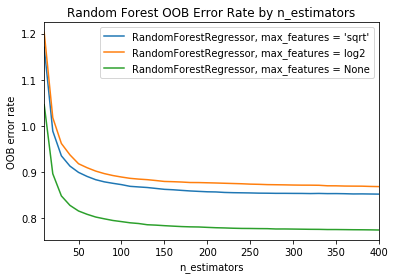

In [48]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor

#This section of code adapted from code by Kian Ho, Gilles Louppe, and Andreas Meuller
#found in sklearn documentation at:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-
#auto-examples-ensemble-plot-ensemble-oob-py

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

random_state = 42

# Generate a binary classification dataset.
#X, y = make_classification(n_samples = 500, n_features=25,
#                           n_clusters_per_class = 1, n_informative = 15,
#                           random_state = random_state)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestRegressor, max_features = 'sqrt'",
        RandomForestRegressor(n_estimators = 100,
                               warm_start = True,
                               oob_score = True,
                               max_features = "sqrt",
                               random_state = random_state,
                               n_jobs = -1)),
    ("RandomForestRegressor, max_features = log2",
        RandomForestRegressor(n_estimators = 100,
                               warm_start = True,
                               max_features = 'log2',
                               oob_score = True,
                               random_state = random_state,
                               n_jobs = -1)),
    ("RandomForestRegressor, max_features = None",
        RandomForestRegressor(n_estimators = 100,
                               warm_start = True,
                               max_features = None,
                               oob_score = True,
                               random_state = random_state,
                               n_jobs = -1))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 400

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 10):
        clf.set_params(n_estimators = i)
        clf.fit(X_2_train, y_2_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.title('Random Forest OOB Error Rate by n_estimators')
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc = "upper right")
plt.show()

The base model used 100 for `n_estimators`, but the gains don't really level off until the 200-300 range. The OOB error is lowest using all features (`max_features` = None), so i will select 400 `n_estimators` and `None` for `max_features`

In [49]:
rf_3 = RandomForestRegressor(n_estimators = 400, max_features = None, n_jobs = -1, random_state = 42, oob_score = True)

rf_3.fit(X_2_train, y_2_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [50]:
rf_3_predictions = rf_3.predict(X_2_validation)
rf_3_train_score = rf_3.score(X_2_train, y_2_train)
rf_3_validation_score = rf_3.score(X_2_validation, y_2_validation)
rf_3_mae = np.mean(abs(rf_3_predictions - y_2_validation))
rf_3_rmse = np.sqrt(mean_squared_error(y_2_validation, rf_3_predictions))

In [51]:
print('Base Random Forest:')
print(' Train Score:      ', rf_train_score)
print(' OOB Score:        ', rf.oob_score_)
print(' Validation Score: ', rf_validation_score)
print(' MAE:              ', rf_mae)
print(' RMSE:             ', rf_rmse)
print('Tuned Random Forest:')
print(' Train Score:      ', rf_3_train_score)
print(' OOB Score:        ', rf_3.oob_score_)
print(' Validation Score: ', rf_3_validation_score)
print(' MAE:              ', rf_3_mae)
print(' RMSE:             ', rf_3_rmse)

Base Random Forest:
 Train Score:       0.8911574507001414
 OOB Score:         0.2091389903552513
 Validation Score:  0.22654432048097828
 MAE:               0.14282674792741365
 RMSE:              0.2303030269818964
Tuned Random Forest:
 Train Score:       0.8949052656303671
 OOB Score:         0.22589766323511917
 Validation Score:  0.23205994807493768
 MAE:               0.14312376697339443
 RMSE:              0.22948039519534782


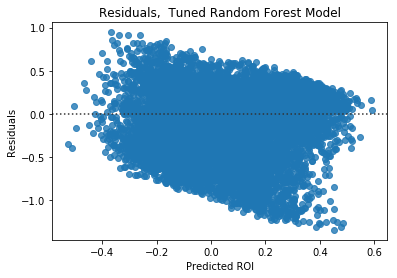

In [52]:
sns.residplot(x = rf_3_predictions, y = y_validation - rf_3_predictions)
plt.title('Residuals,  Tuned Random Forest Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

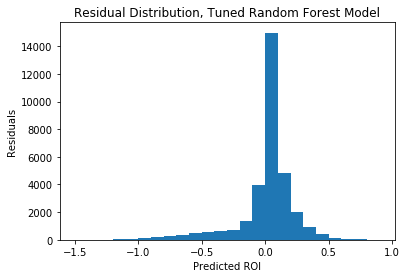

In [53]:
plt.hist(y_validation - rf_3_predictions, bins = np.arange(-1.5, 1, 0.1))
plt.title('Residual Distribution, Tuned Random Forest Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

In [54]:
rf_3_90_percentile = calculate_residual_percentile(rf_3_predictions, y_validation ,90)
print('Tuned Random Forest Residuals, 90th percentile: ', rf_3_90_percentile)

Tuned Random Forest Residuals, 90th percentile:  (-0.6437, 0.2552)


The hyperparameter tuning helped improve the validation score from 0.2265 to 0.2321, and also dropped the RMSE slightly, however, the MAE oddly increased slightly, meaning there may be some more extreme residuals.  The tuning did not help with the overfitting, and the odd difference between the train and test residuals is still seen in the residual plot.

#### Gradient Boost Tuning

To tune the gradient boost model, I will set up a parameter grid and do a grid search to determine which parameters yield the highest score on the validation set. I will search over the `max_depth`, `learning_rate`, `min_samples_leaf`, and `max_features` hyperparameters, all with an increased `n_estimators` parameter of 1000.

In [55]:
from sklearn.model_selection import ParameterGrid

param_grid = {'learning_rate' : [0.1, 0.05, 0.02], #default 0.1
              'min_samples_leaf' : [1,3], #default 1
              'max_features' : [1, 0.5, 0.2]} #default none (all)

boost_2 = GradientBoostingRegressor(n_estimators = 1000, random_state = 42)

In [56]:
scores = []
best_score = 0
best_param = {}

for p in ParameterGrid(param_grid):
    boost_2.set_params(**p)
    boost_2.fit(X_2_train, y_2_train)
    score = boost_2.score(X_2_validation, y_2_validation)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_param = p

In [57]:
print(best_param)
print(best_score)

{'learning_rate': 0.1, 'max_features': 0.5, 'min_samples_leaf': 1}
0.24594772793165753


The best scoring was found with a learning rate of 0.01, max features of 0.5, and minimum samples leaf of 1.

In [58]:
boost_3 = GradientBoostingRegressor(n_estimators = 1000,
                                        learning_rate = 0.1,
                                        max_features = 0.5,
                                        min_samples_leaf = 3,
                                        random_state = 42)
boost_3.fit(X_2_train, y_2_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=0.5,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
boost_3_predictions = boost_3.predict(X_2_validation)
boost_3_train_score = boost_3.score(X_2_train, y_2_train)
boost_3_validation_score = boost_3.score(X_2_validation, y_2_validation)
boost_3_mae = np.mean(abs(boost_3_predictions - y_2_validation))
boost_3_rmse = np.sqrt(mean_squared_error(y_2_validation, boost_3_predictions))
print('Base Gradient Boost:')
print(' Train Score:      ', boost_train_score)
print(' Validation Score: ', boost_validation_score)
print(' MAE:              ', boost_mae)
print(' RSME:             ', boost_rmse)
print('.'*72)
print('Tuned Gradient Boost:')
print(' Train Score:      ', boost_3_train_score)
print(' Validation Score: ', boost_3_validation_score)
print(' MAE:              ', boost_3_mae)
print(' RSME:             ', boost_3_rmse)

Base Gradient Boost:
 Train Score:       0.20073252680517573
 Validation Score:  0.19409240226094393
 MAE:               0.14550951589814887
 RSME:              0.2350848027878787
........................................................................
Tuned Gradient Boost:
 Train Score:       0.30792057388372207
 Validation Score:  0.2455816989591735
 MAE:               0.13931332808709188
 RSME:              0.2274510977993755


The gradient boost tuning provided a decent gain in validation scores from 0.19409 to 0.24595, while also reducing the MAE and RMSE.

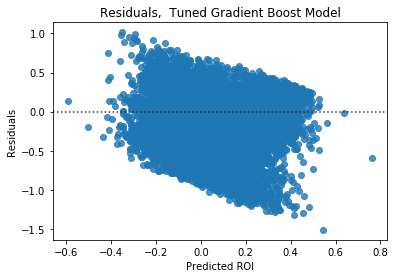

In [60]:
sns.residplot(x = boost_3_predictions, y = y_validation - boost_3_predictions)
plt.title('Residuals,  Tuned Gradient Boost Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

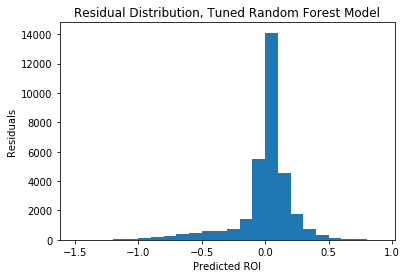

In [61]:
plt.hist(y_validation - boost_3_predictions, bins = np.arange(-1.5, 1, 0.1))
plt.title('Residual Distribution, Tuned Random Forest Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

In [62]:
boost_3_90_percentile = calculate_residual_percentile(boost_3_predictions, y_validation ,90)
print('Tuned Gradient Boost Residuals, 90th percentile: ', boost_3_90_percentile)

Tuned Gradient Boost Residuals, 90th percentile:  (-0.6221, 0.2407)


## Model Selection

#### Model Selection

In [63]:
print('Tuned Linear Regression (Lasso):')
print(' Train Score:      ', lasso_train_score)
print(' Validation Score: ', lasso_validation_score)
print(' MAE:              ', lasso_mae)
print(' RMSE:             ', lasso_rmse)
print('-'*72)
print('Tuned Random Forest:')
print(' Train Score:      ', rf_3_train_score)
print(' Validation Score: ', rf_3_validation_score)
print(' MAE:              ', rf_3_mae)
print(' RMSE:             ', rf_3_rmse)
print('-'*72)
print('Tuned Gradient Boost:')
print(' Train Score:      ', boost_3_train_score)
print(' Validation Score: ', boost_3_validation_score)
print(' MAE:              ', boost_3_mae)
print(' RSME:             ', boost_3_rmse)

Tuned Linear Regression (Lasso):
 Train Score:       0.048084135149472296
 Validation Score:  0.04759936851391777
 MAE:               0.16346891966433677
 RMSE:              0.2555593454110179
------------------------------------------------------------------------
Tuned Random Forest:
 Train Score:       0.8949052656303671
 Validation Score:  0.23205994807493768
 MAE:               0.14312376697339443
 RMSE:              0.22948039519534782
------------------------------------------------------------------------
Tuned Gradient Boost:
 Train Score:       0.30792057388372207
 Validation Score:  0.2455816989591735
 MAE:               0.13931332808709188
 RSME:              0.2274510977993755


After tuning, the gradient boost has the highest validation score and the lowest MAE and RMSE, and thus will be the model selected.

To best estimate how this model will perform on unseen data, I will do one final fit on all available data except the test data (the train and validation data), and evaluate the results on the test data.

## Findings

In [64]:
final_boost_model = GradientBoostingRegressor(n_estimators = 1000,
                                              learning_rate = 0.1,
                                              max_features = 0.5,
                                              min_samples_leaf = 1,
                                              random_state = 42)
final_boost_model.fit(X_2_intermediate, y_2_intermediate)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=0.5,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
final_predictions = final_boost_model.predict(X_2_test)
final_predictions_train_score = final_boost_model.score(X_2_intermediate, y_2_intermediate)
final_predictions_test_score = final_boost_model.score(X_2_test, y_2_test)
final_predictions_mae = np.mean(abs(final_predictions - y_2_test))
final_predictions_3_rmse = np.sqrt(mean_squared_error(y_2_test, final_predictions))

In [66]:
print('Final Model  Scoring:')
print(' Train Score:      ', final_predictions_train_score)
print(' Test Score:       ', final_predictions_test_score)
print(' MAE:              ', final_predictions_mae)
print(' RSME:             ', final_predictions_3_rmse)

Final Model  Scoring:
 Train Score:       0.29751510294303507
 Test Score:        0.2545382897527162
 MAE:               0.13709964105654646
 RSME:              0.2223468467789649


The final results are a test R-squared value of 0.2545, a MAE of 0.1371, and a RMSE of 0.2223.     

To see how these results translate in their ability to help with the original business case, I will run some scenarios.

In the first scenario, I will try to simulate the results that could happen if an investor had no model at all and randomly chose a loan, and compare that to what might be expected if a lender used the model, and only invested in loans that have a predicted ROI above the 95th percentile.  I am picking the top 5 percent because not all loans are available at any given time so it isn't realistic to only select the few with the highest predicted ROI, and it will give me an large enough sample of loans to get an idea of the distribution of ROIs for those loans.

In [ ]:
X_2_test['roi']= y_test
X_2_test['predicted_roi']= final_predictions

In [68]:
np.mean(X_2_test.roi)

0.12192684154217535

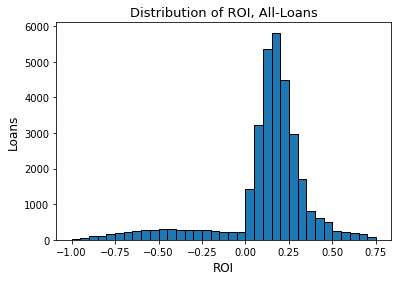

In [69]:
plt.hist(X_2_test.roi, bins = np.arange(-1, 0.8, 0.05), edgecolor = 'black')
plt.title('Distribution of ROI, All-Loans', size = 13)
plt.xlabel('ROI', size = 12)
plt.ylabel('Loans', size = 12)
plt.show()

In [70]:
from scipy.stats import percentileofscore
loss_percent_all = percentileofscore(X_2_test.roi, 0)
print('Percent of loans with negative ROI, no model: ', round(loss_percent_all,2),'%')

Percent of loans with negative ROI, no model:  13.25 %


Choosing loans at random, an investor would expect an average ROI of 0.12.  The distribution shows that most loans have an ROI between zero and 0.35, with a long tail of loans that have a negative ROI, and few loans with an ROI above 0.35.

Next I will look at the loans with a predicted ROI above the 95th percentile, and see what the average actual ROIs and their distribution looks like.

In [71]:
percentile = np.percentile(X_2_test['predicted_roi'],95)
percentile

0.30462693280562425

In [72]:
X_2_best_predictions = X_2_test.query('predicted_roi > @percentile')

In [73]:
np.mean(X_2_best_predictions.roi)

0.36786639552749756

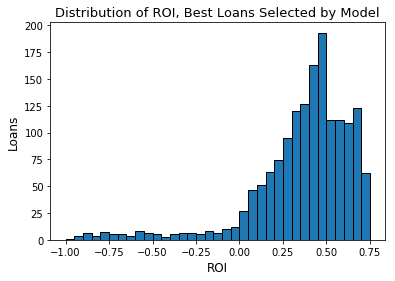

In [74]:
plt.hist(X_2_best_predictions.roi, bins = np.arange(-1, 0.8, 0.05), edgecolor = 'black')
plt.title('Distribution of ROI, Best Loans Selected by Model', size = 13)
plt.xlabel('ROI', size = 12)
plt.ylabel('Loans', size = 12)
plt.show()

In [75]:
loss_percent_best = percentileofscore(X_2_best_predictions.roi, 0)
print('Percent of loans with negative ROI using model: ', round(loss_percent_best,2),'%')

Percent of loans with negative ROI using model:  7.21 %


Choosing the models that are only in the top 5 percentile of the loan predictions results in a much better distribution of actual ROI.  By only choosing from the top ROI predictions, the mean ROI increases from 12.2% to 36.8%. There are many more loans with an ROI above 35% in the loans selected from the model compared to the loans selected at random. There is still a long tail of negative-ROI loans, meaning that there is still a risk of losing money, but it is lower than choosing loans at random. In the total population of loans, 13.25% had a negative ROI, but it is reduced to 7.21% among the top loans chosen by the model.

The following plot shows both distributions overlapping, where it is easy to see the improvement in ROI by selecting the from the highest predictions (green) compared to selecting loans at random (blue).


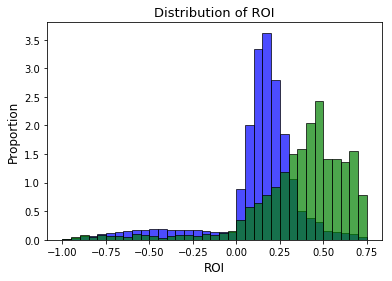

In [88]:
plt.hist(X_2_test.roi, bins = np.arange(-1, 0.8, 0.05),
         edgecolor = 'black',
         density = True,
         color = 'blue', alpha = 0.7)
plt.hist(X_2_best_predictions.roi, bins = np.arange(-1, 0.8, 0.05),
         edgecolor = 'black',
         density = True,
         color = 'green', alpha = 0.7)
plt.title('Distribution of ROI', size = 13)
plt.xlabel('ROI', size = 12)
plt.ylabel('Proportion', size = 12)
plt.show()

For the second scenario, I will assume most investors don’t just select  loans at random.  While I can’t run a scenario for all investment strategies, I can create a scenario from the earlier discussion of loan grade and purpose. E-grade loans have the highest average ROI, but are also riskier than higher grade loans.  Also, I will exclude small business loans, since it was discovered that they have both the lowest average ROI and higher risk of default than the other loan purposes. In this scenario, I will compare the results of using the model to select the best loans, with the results of an investor who has a strategy to  improve their mean ROI by selecting E grade loans, that are not for small businesses. 

Again, I’ll look at the distribution of ROIs as well as the average ROI and percentage of loans with a negative ROI.


In [ ]:
X_2_test['grade_E'] = X_test['grade_E']
e_grade_loans = X_2_test.query('grade_E > 0')
e_grade_loans = e_grade_loans.query('purpose_small_business < 1')

In [78]:
print('Mean ROI, E-grade loans: ',round(np.mean(e_grade_loans.roi) *100,2),'%')

Mean ROI, E-grade loans:  17.32 %


In [79]:
loss_percent_e = percentileofscore(e_grade_loans.roi, 0)
print('Percent of loans with negative ROI choosing E-Grade: ', round(loss_percent_e, 2), "%")

Percent of loans with negative ROI choosing E-Grade:  22.04 %


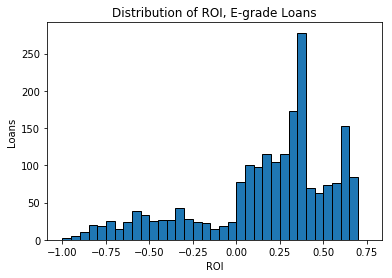

In [80]:
plt.hist(e_grade_loans.roi, bins = np.arange(-1, 0.8, 0.05), edgecolor = 'black')
plt.title('Distribution of ROI, E-grade Loans')
plt.xlabel('ROI')
plt.ylabel('Loans')
plt.show()

In [81]:
print('Mean ROI, Loans selected by model: ', round(np.mean(X_2_best_predictions.roi) * 100,2),'%')

Mean ROI, Loans selected by model:  36.79 %


In [82]:
print('Percent of loans with negative ROI using model: ', round(loss_percent_best,2),'%')

Percent of loans with negative ROI using model:  7.21 %


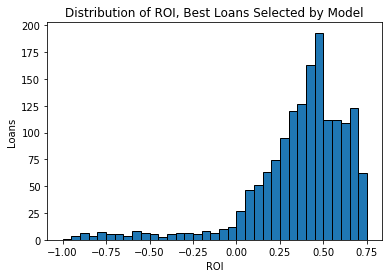

In [83]:
plt.hist(X_2_best_predictions.roi, bins = np.arange(-1, 0.8, 0.05), edgecolor = 'black')
plt.title('Distribution of ROI, Best Loans Selected by Model')
plt.xlabel('ROI')
plt.ylabel('Loans')
plt.show()

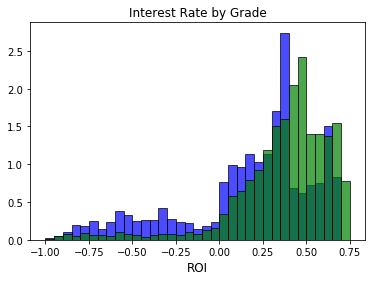

In [90]:
plt.hist(e_grade_loans.roi, bins = np.arange(-1, 0.8, 0.05),
         edgecolor = 'black',
         density = True,
         color = 'blue', alpha = 0.7)
plt.hist(X_2_best_predictions.roi, bins = np.arange(-1, 0.8, 0.05),
         edgecolor = 'black',
         density = True,
         color = 'green', alpha = 0.7)
plt.title('Distribution of ROI', size = 13)
plt.xlabel('ROI', size = 12)
plt.title('Interest Rate by Grade')
plt.show()

I'll take a look at the risk again by comparing the proportion of loans with negative ROI between the e-grade loans and the loans chosen by the model.

E-Grade loans excluding small business loans have a mean ROI of 17.32% compared to 12.2% for all loans. There is a larger proportion above 35% ROI than choosing from all loans at random, but there is also a higher proportion of loans with a negative ROI. In this scenario, investors are still better off selecting from the model’s top predictions that choosing the e-grade loans that are not for small business, but by a smaller margin. The following plot overlaps the egrade loans(blue) with the loans from the top predictions(green).

There is much more overlap in this scenario, but some important differences for investors.  The loans chosen by the model have a much lower risk than choosing E-grade loans excluding small business loans, as shown by the much smaller proportion of loans with negative ROI. Another important thing for investors is the higher proportion of the loans chosen by the model with an ROI above 40%.  

### Further Reserach

There are many areas of further research that could offer more help to loan investors.  First, the linear regression is performing poorly compared to the other models, likely due to high  bias/underfitting.  This could be the result of making false assumptions of linearity of the data. Further research could be done to check the variables for linearity and to see if the model could be improved by transforming some variables. 


Another area of further research is to look at scenarios for different investment strategies. For example, risk-averse investors are more likely to invest in A and B grade loans because they are willing to trade a lower average ROI for lower risk. It would be interesting to see how much the model would help these investors, and whether it would allow for a higher average ROI without increasing the low risk. 


Research could also be done based on the length of loan, which is either 36 or 60 months. For this project they were grouped together, with the length as a predictor variable, however it would be interesting to model them separately and see the results. It would also allow for more recent data to be used in the case of 36 month loans.


### Client Recommendations


Using the machine learning model can help peer-to-peer loan investors both increase their ROI, and decrease the risk of losing money on loans.  The benefit of the model is unique to each investor’s strategy for choosing loans to invest in.

When choosing loans at random, using the model is highly beneficial.  The ROI is projected to increase from 12.2% to 36.8%, more than tripling the returns.  For 100,000 invested, average earnings are expected to increase from 12,200 to 36,600. 

For investors willing to invest in higher-risk, higher return E-Grade loans, using the model is expected to increase the ROI  from 17.32% to 36.8%, while substantially reducing the risk that any given loan will have a negative return, dropping fromm 22% of loans down to 7.2% of loans.

For other investment strategies, I recommend calculating the summary statistics of the data to see the average ROI and percent of loans with a negative ROI that are expected using that strategy, and compare the results to using the model.

One final word of caution: Since the length of the loans is up to 60 months, the data used to build the models had to be at least 60 months old,  since the ROI would otherwise not be known. I expect the accuracy of the models to erode over time due to changes over the last 5-7 years, such as economic changes or changes to the way the data is collected and categorized. The model would certainly have been helpful for choosing loans to invest in from  2012 to 2013, but there is uncertainty in how helpful the model will be for choosing loans that originate today.  Still, many  of the same general principles  that were true 5-7 years ago will be true today, and the model should still offer a higher ROI and less risk for an investor.
